# Credit Risk
# Bachelor Thesis - Bocconi University 

## Credit risk modelling: an empirical analysis on Probability of Default (PD) estimation 
solution provided by: **Daniel Travaglia**

## Draft of the outline of the notebook

0. Introduction: frame the problem
1. Prerequisites: set up the environment
2. Retrieve and describe the dataset
3. Discover and visualize data for reacher insights 
4. Data cleaning for modelling (missing values) 
5. Machine Learning Pipelines:
    - Model (1): Logistic Regression Model
        1. Data prepocessing and model definition
        2. Model better evaluation using cross validation and fine-tuning model parameters using grid search
        3. Retrieve the optimal model 
    - Model (2): Ensemble Model (Gradient Boosting)
        1. Data preprocessing and model definition
        2. Model better evaluation using cross validation and fine-tuning model parameters using grid search
        3. Retrieve the optimal model
6. Get the best model (metric comparison)
7. Evaluate the system on the test set and plot the results
8. Conclusions
9. (Bonus) Further improvements

## TODO

2) [TODO -> Today] Explanatory analysis + Give appropriate introduction and description

3) [TODO -> Today/Tomorrow] Calibration of default probability: since we do not have time-series data, we could actually calibrate default probabilities per-group: group by ratings and then by whether the client defaulted or not. At this point, estimate the probability of defaulting (modelling using a Bernoulli RV then) by calculating the proportion of defaulted clients out of the total clients for that specific rating 

4) [TODO -> Tomorrow] -> Provide a high-level overview of the credit risk world, with a particular attention in being able to introduce the topic in an understandable manner!

5) [TODO -> Today] -> injecting interest rates (missings) based on the information provided by ratings (random sampling between min-max of int. rates for a specific ranking) -> replacing missing values

# (0) Introduction: frame the problem

[TODO]: Provide a high-level description of what is credit risk modelling, what characterize it and how this activity is usually done in financial istitutions. Particular attention on PD, EAD and LGD.

# (1) Set up the environment

In this section the core libraries that will be used throughout the entire notebook are loaded. 
* NumPy and Pandas provide the fundamental tools to handle datasets and arrays.
* Skikit-learn provides amazing tools that simplify quite significantly the modelling part.
* Last but not least, matplotlib and seaborn are amazing libraries that enables to create effective visualizations to explore the data even further.

### (0.1) Retrieving libraries

In [1]:
# Data manipulation ML libraries
import numpy as np 
import pandas as pd
from scipy import stats
from scipy.stats import norm

# Ignore irrelevant warnings to make the code nicer!
import warnings
warnings.filterwarnings('ignore')

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 

# database libraries
import pyodbc                       

# graphic settings
# Make things work smoother for plots
%matplotlib inline
# Se the backend of plotting to matplotlib
pd.options.plotting.backend = 'matplotlib'
# Change the style of seaborn graphs
sns.set(
    style="white", 
    palette="Blues_r", 
    color_codes=True, 
    font_scale=1.1
)

### (0.1) Loading data settings

In [2]:
## CSV
# Counterparty data path
cp_path = "data\counterparty.csv"
# Counterparty loans data path
loans_path = "data\counterparty_loans.csv"

In [3]:
## SQL Server

# # Defining connection string
# driver = "{SQL Server}"
# server = "DESKTOP-KI4LIGE" # retrieve this in SQL by typing @@SERVERNAME
# database = "Thesis"
# connection = "yes"
# conn_string = f"Driver={driver};Server={server};Database={database};Trusted_Connection={connection}"

# # Defining connection string
# conn = pyodbc.connect(conn_string)

# # Defining query to extract data from tables
# sql_cp_query = """
#     SELECT * 
#     FROM dbo.Counterparty
# """
# sql_cp_loans_query = """
#     SELECT *
#     FROM dbo.Counterparty_loan
# """

In [4]:
# MongoDB

# (2) Retrieve and describe the dataset

Goal of this section is to provide information on the structure of the dataset used for the analysis. To begin with, a high-level description of the two tables will be given. Later on, by getting out hands dirty with the data, we will take a closer look at the data and conduct a sanity check to see whether the data is consistent and in line with expectations.

## (2.1) Loading the datasets

The data are spread across 2 different tables:

* **Counterparty**: this dataset contains some general characteristics and information regarding the counterparties 
* **Loans**: this dataset is equipped with relevant information on the loans provided by a financial istitution.

Before proceeding, it is important to clarify an relevant characteristic of our data. As we will see later, each counterparty from the "counterparty" table is associated with one (and only one) loan from the "loans" table. This means that there is a one-to-one mapping between counterparties and loans, which is not usually corresponding to a classic scenario within a financial or any other credit lending istitution that wish to model some credit risk metrics. Indeed, the latters make use of time-series data, which often provide a credit history of all the accounts (i.e. each financial instruments that the financial istitution can provide to the client) for multiple periods. In this context, the scenario is completely different: we are dealing with a panel data. In particular, each observation represents a snapshot of the credit availability associated with a counterparty at a certain point in time that is shared among all the observations. In other words, we get rid of the time dimension. Clearly, this translates into two different approaches to estimate probability of default. A financial istitution might want to model the PD ("probability of default") taking into account factors that are time-dependent (e.g. market risk factor, macroeconomic scenarios and so ). Given the nature and the structure of the data however, will force us in keeping things simple with a much less ambitious objective: we would like to estimate the proability that a counteparty default on its obligations by taking into consideration its characteristics and that of the financial obligation.

### (2.1.1) Retrieving data from CSV

In [80]:
# Retrieving counterparty data
df_cp = pd.read_csv(cp_path)
# Retrieving counterparty loans data
df_loans = pd.read_csv(loans_path)

# make sure the file is loaded
assert not (df_cp.empty and df_loans.empty)

### (2.1.2) Retrieving data from SQL server

In [6]:
# # Injecting data into pandas DateFrame
# df_cp = pd.read_sql(sql_cp_query,conn)
# df_loans = pd.read_sql(sql_cp_loans_query,conn)

# # Inspecting whether we have indeed extract something out of the SQL server
# assert not (df_cp.empty or df_loans.empty)

### (2.1.3) Retrieving data from MongoDB server

In [7]:
# MongoDB

## (2.2) A first glence at the data

After loading the dataset, we are ready to get our hands dirty. We will first explore the counterparty table, from its shape to some concrete of examples that are store in it to verify consistency in the data. We will then proceed with the same type of analysis on the loan table and, evenutally, we will merge the two dataset to retrieve additional insights with a combined analysis.

### (2.2.1) Counterparties dataset

In [8]:
df_cp.shape

(32581, 7)

The counterparty dataset contains 32581 observations, each of which represents a specific counterparty. The latters are described is then described by 7 different features. Let's now dig a little bit more to discover what type of information we have on the counterparties

In [9]:
df_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_cp                       32581 non-null  int64  
 1   cp_age                      32581 non-null  int64  
 2   cp_income                   32581 non-null  int64  
 3   cp_home_ownership           32581 non-null  object 
 4   cp_emp_length               31686 non-null  float64
 5   cp_person_default_on_file   32581 non-null  object 
 6   cp_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 1.7+ MB


The dataset provides the following information regarding the counterparties: 
* Age: age of the person 
* Income: personal income in $ (dollars)
* Home ownership: whether the person owns a house or it is supplied with in other ways (RENT, MORTGAGE, ... or other financial instruments)
* Employment length: how long (in years) the person has been employed
* Person default on file: whether in the past the person has already defaulted or not on an obligation
* Credit history length: length of the credit grant in years up until now

Let's clarify some points that emerge from this simple table

1. It can be easily noticed that some observations for "employment length" variable are missing. This is a situation that must be handled somehow before proceeding into the modelling section

2. We want to turn some variables (e.g. home ownership and person default on file) into categorical features. Such procedure will simplify our analysis quite significantly and it will be specially relevant for the modelling part.

At this point you might wonder: how's the data looks like?

In [10]:
df_cp.head()

id_cp  cp_age  cp_income cp_home_ownership  cp_emp_length  \
0      1      22      59000              RENT          123.0   
1      2      21       9600               OWN            5.0   
2      3      25       9600          MORTGAGE            1.0   
3      4      23      65500              RENT            4.0   
4      5      24      54400              RENT            8.0   

  cp_person_default_on_file  cp_person_cred_hist_length  
0                         Y                           3  
1                         N                           2  
2                         N                           3  
3                         N                           2  
4                         Y                           4

It seems that we have relevant information regarding the counterparties. It is worth discussing on the following point before proceeding: 

* Presence of outliers: the first observation is characterized by a value for "employment length" that is clearly out of range: how could a person be employed for 123 years? And how would it be possible for a 22 years old person in the first place?

* The issue highlighted above might have further implications which are probably worth discussing before proceeding: we already hightlighted how it is important in a analytical project to have a rough idea of what each variable represents. If combined with a proper explanatory analysis (which will be provided later), it is possible to spot most of the inconsistencies in the data (i.e. bad outliers). However, this might not be enough: the counterparty could provide false information to the istitution providing the loan to increase the likelihood of obtaining the credit. Such setting is usually worsen by the presence of asymmetric information between the two parties. Indeed, the fact that one party is more informed that the other party might generate some inefficencies in the lending market. This topic will be subject of discussion for the last chapter of this paper.

Let's explore some statistics to see whether there is presence of other inconsistencies in the data.

In [11]:
df_cp.describe()

id_cp        cp_age     cp_income  cp_emp_length  \
count  32581.000000  32581.000000  3.258100e+04   31686.000000   
mean   16291.000000     27.734600  6.607485e+04       4.789686   
std     9405.468897      6.348078  6.198312e+04       4.142630   
min        1.000000     20.000000  4.000000e+03       0.000000   
25%     8146.000000     23.000000  3.850000e+04       2.000000   
50%    16291.000000     26.000000  5.500000e+04       4.000000   
75%    24436.000000     30.000000  7.920000e+04       7.000000   
max    32581.000000    144.000000  6.000000e+06     123.000000   

       cp_person_cred_hist_length  
count                32581.000000  
mean                     5.804211  
std                      4.055001  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

This table allows us to easily identify the incosistencies mentioned above: the maximum employment length among all observations is 123 years. In addition, the maximum registred age for a counterparty is 144 years. Such values will definetely require further investigation and manipulation to obtain a dataset on top of which we can work on. There seems to be also unemployed counterparties who took up a loan. All the other numbers seem to be reasonably acceptable.

Removing inconsistencies from the counterparty table: people aged above 100 along with those that have more than 50 years of employment

In [96]:
# Retrieve the number of values which are not reasonable
df_invalid = df_cp[(df_cp.cp_age > 100) | (df_cp.cp_emp_length > 50)]
# Dropping absurd values from the dataset
df_cp.drop(index=df_invalid.index,inplace=True)

### (2.2.1.1) Univariate analysis on counterparty's data

This section aims at exploring the counterparties' features even further through some visualization tools. Particular attention will be given to the distribution of the data and whether it is possible to discover something more

In [136]:
# Create a copy for analysis purposes
df_cp_analysis = df_cp.copy().drop(columns=["id_cp"]).dropna()

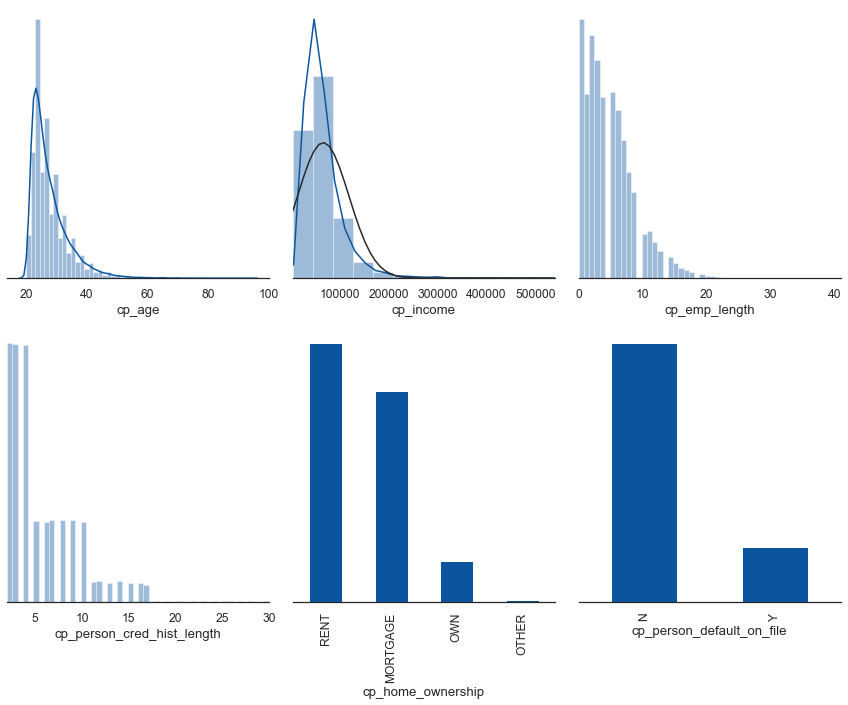

In [53]:
# Set up the matplotlib figure
f, axes = plt.subplots(2, 3, figsize=(12, 10))
sns.despine(left=True)

# Univariate distributions

# (1) Age distribution (with no density estimation)
fig_age = sns.distplot(df_cp_analysis.cp_age,kde=True,ax=axes[0,0])
# fig_age.axis(xmin=df_cp_analysis.cp_age.min() - 10, xmax=df_cp_analysis.cp_age.max() + 10)

# (2) Income distribution (with density estimation)
fig_income = sns.distplot(df_cp_analysis.cp_income,kde=True,ax=axes[0,1],fit=norm)
fig_income.axis(xmin=df_cp_analysis.cp_income.min(), xmax=df_cp_analysis.cp_income.max() - 1.5e6)

# (3) Employment length distribution (with density estimation)
fig_emp_leng = sns.distplot(df_cp_analysis.cp_emp_length,kde=False,ax=axes[0,2])
fig_emp_leng.axis(xmin=df_cp_analysis.cp_emp_length.min(), xmax=df_cp_analysis.cp_emp_length.max())

# (4) Credit history length distribution (with no density estimation)
fig_cr_hist = sns.distplot(df_cp_analysis.cp_person_cred_hist_length,kde=False,ax=axes[1,0])
fig_cr_hist.axis(xmin=df_cp_analysis.cp_person_cred_hist_length.min(), xmax=df_cp_analysis.cp_person_cred_hist_length.max())

# (5) Home ownership data 
fig_home = df_cp_analysis.groupby(["cp_home_ownership"])["cp_home_ownership"].count().sort_values(ascending=False).plot(kind="bar",ax=axes[1,1])

# (6) Whether the counterparty defaulted or not in the past 
fig_def = df_cp_analysis.groupby(["cp_person_default_on_file"])["cp_person_default_on_file"].count().sort_values(ascending=False).plot(kind="bar",ax=axes[1,2])

plt.setp(axes, yticks=[])
plt.tight_layout()

The image above includes the univariate distribution of all the numerical features of the counterparty dataset as well as some quantitative results for all the categorical data. Few things stand out here:

* As we have already noticed, almost the entire set of the counterparties in this dataset are people between their 20s and their 40s. Obviously, this translates into shorter employment and credit history length, or in other words, these variables are, by nature, dependent. The question is whether these variables would inject the same information or not when there will be the need to model the probability of default of a counterparty on the loan

* A very small number of counterparties owns a house, while the majority is either renting or on a mortgage. The latters would proably need higher attention in future analysis, as these people already took upon themselves other debt to be repaid at a certain poin in time. Hence, the question becomes whether people would have enough income to sustain another obligation for an extended period of time.

* The most representative class of counterparties have not defaulted in the past on a obligation. However, given the age distribution, this was somewhat expected, while the opposite would have been surprising. In any case, this information should turn out to be of massive importance in modelling the PD.

* Lastly, the income distribution, as expected, is skewed to the left and the plot against a gaussian density seems to confirm this hypothesis. Why is this important? Well, the relevance of having normally distributed features is because several tests (e.g. t-statistic) assume that it is dealing with a normally distributed data. 

Before proceeding with the dataframe that describe the loans, let's have a look at some of the points mentioned above individually.

Check for normality 

((array([-4.09313566, -3.88270211, -3.76778863, ...,  3.76778863,
          3.88270211,  4.09313566]),
  array([   4000,    4080,    4200, ..., 1782000, 1900000, 2039784],
        dtype=int64)),
 (39943.12512045902, 65878.4808129183, 0.7602773694989742))

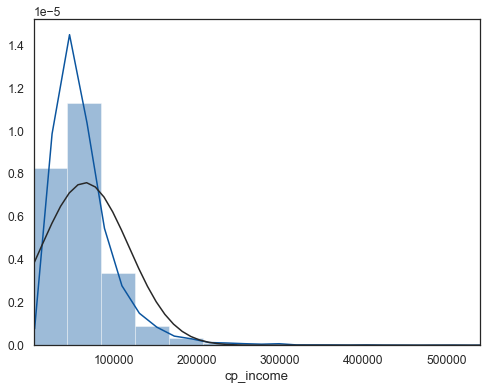

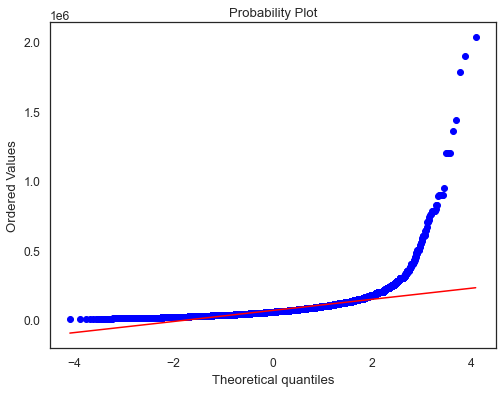

In [60]:
# Normality of counterparty income
fig_age = plt.figure(figsize=(8,6))
fig_age = sns.distplot(df_cp_analysis.cp_income,kde=True,fit=norm)
fig_age.axis(xmin=df_cp_analysis.cp_income.min(), xmax=df_cp_analysis.cp_income.max() - 1.5e6)

# QQ Plot
fig = plt.figure(figsize=(8,6))
stats.probplot(df_cp_analysis.cp_income,plot=plt)

Try to achieve normality through a simple monotonic transformation: logarithmic. Such transformation will just affect the underlying distribution of the feature, but will not have any affect on all the other characteristics of the data (e.g. min and max)

((array([-4.09313566, -3.88270211, -3.76778863, ...,  3.76778863,
          3.88270211,  4.09313566]),
  array([0.74930932, 0.75043593, 0.75207797, ..., 0.98086393, 0.98252928,
         0.98436134])),
 (0.021636588176683614, 0.8709349797379925, 0.9959953385734746))

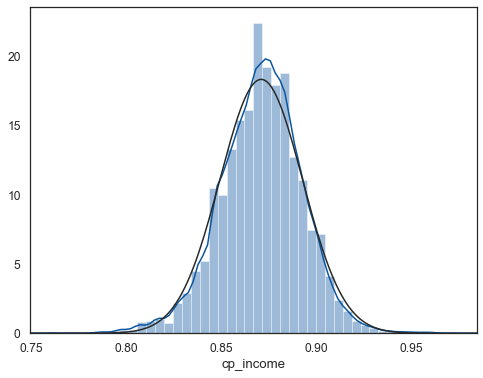

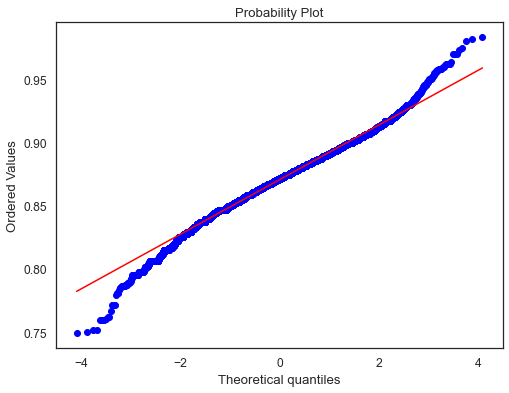

In [63]:
# Apply log transformation
df_cp_analysis.cp_income = np.log(df_cp_analysis.cp_income)

# Reproduce plot
fig_age = plt.figure(figsize=(8,6))
fig_age = sns.distplot(df_cp_analysis.cp_income,kde=True,fit=norm)
fig_age.axis(xmin=df_cp_analysis.cp_income.min(), xmax=df_cp_analysis.cp_income.max())

# QQ Plot
fig = plt.figure(figsize=(8,6))
stats.probplot(df_cp_analysis.cp_income,plot=plt)

Mission accomplished: although it still presents some skewedeness, the distribution is really close to a gaussian one. 

## (2.2.2) Loans dataset

Let's now switch to the loans dataset. This table provides information regarding single loans that were provided to a counterparty by means of a financial istitution

In [135]:
# Dropping useless features for analysis and NAN values
df_loans_analysis = df_loans.drop(columns=["id_loan","fk_cp"]).dropna()
df_loans_analysis.shape

(29465, 6)

The dataset on loans has the same number of observations as the one on counterparties. This is another confirmation of the presence of a one-to-one matching between counterparties and loans. Each loan is described by 6 different features.

In [22]:
df_loans_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_intent          32581 non-null  object 
 1   loan_grade           32581 non-null  object 
 2   loan_amount          32581 non-null  int64  
 3   loan_int_rate        29465 non-null  float64
 4   loan_status          32581 non-null  int64  
 5   loan_percent_income  32581 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.5+ MB


The following information on loans are provided:

* Loan intent: reason declared by the counterparty to get the loan

* Loan grade: the rating associated with the loan and the relative counterparty. This gives us insights on the risk associated with this loan, and it is usually driven by the loan characteristics, as well as counterparties characteristics

* Loan amount: the amount of the loan

* Loan interest rate: the interest rate associated with the loan.

* Loan status: whether the counterparty has defaulted or not on such loan (1 is defaulted, 0 is not). This is going to be our dependent variable: we want to estimate the probability that a customer is going to default given certain characteristics on the loans (loans dataset) along with characteristics on the counterparty itself (counterparty dataset)

* Loan percent income: the proportion of the loan amount with respect to the income of the relative counterparty 

It seems that a huge amount of observations do not have information on the interest rate applied to the loan. Being an indicator of how risky the investment is, one possibility to get rid of these missing values could be represented by applying a map between ratings and interest rates and replace them based on a random sampling within the range of the interest rate for a specific category (i.e. loan_intent) and for the rating characterizing such loan (i.e. loan_grade). Doing so however, there is the risk of injecting biased information in the data that might lead eventually to have bad predictiory power from the model.

In [23]:
df_loans_analysis.head()

loan_intent loan_grade  loan_amount  loan_int_rate  loan_status  \
0    PERSONAL          D        35000          16.02            1   
1   EDUCATION          B         1000          11.14            0   
2     MEDICAL          C         5500          12.87            1   
3     MEDICAL          C        35000          15.23            1   
4     MEDICAL          C        35000          14.27            1   

   loan_percent_income  
0                 0.59  
1                 0.10  
2                 0.57  
3                 0.53  
4                 0.55

The first observations do not signal any particular concern on the data. Let's see whether this is also confirmed by the statistics.

In [24]:
df_loans_analysis.describe()

loan_amount  loan_int_rate   loan_status  loan_percent_income
count  32581.000000   29465.000000  32581.000000         32581.000000
mean    9589.371106      11.011695      0.218164             0.170203
std     6322.086646       3.240459      0.413006             0.106782
min      500.000000       5.420000      0.000000             0.000000
25%     5000.000000       7.900000      0.000000             0.090000
50%     8000.000000      10.990000      0.000000             0.150000
75%    12200.000000      13.470000      0.000000             0.230000
max    35000.000000      23.220000      1.000000             0.830000

All the numerical features seem reasonably within the expected range. However, it seems that there are some observations that show a loan amount w.r.t. the income of the counterparty to be equal to 0, despite the minumum loan amount being equal to 500. This signal presence of inconsistencies that should be carefully analyzed and handled as soon as we have a comprehensive view of each loan with its respective counterparty. Moreover, few things can already be highlighted here before proceeding with the analysis:

1) As we have seen before, "loan status" is a binary feature: it only takes values 1 or 0 depending on whether the counterparty already defaulted or not on the loan respectively. The average value of the distribution of this feature is skewed towards 0, which suggests that we are provided with an unbalanced set. In other words, there is presence of more non-defaulting loans than the defaulted ones. However, as we will see later in this analysis, such finding will not have any impact on the model.

2) Suspicious numbers in the "loan over income" feature will be subject of later analysis. However, the mean and the standard deviation of the distribution of this feature suggest that the amount of the loans is just a small percentage of the overall counterparty's income. This might be a good reason for which we have many more non-defaulting loans in the dataset, but such assumption would definetely require a much closer look at the data.

3) The average interest rate on loans is pretty high with respect to the distribution of the loan amounts, but given the number of non-defaulting loans, this figure should be to be sustainable in the long-term by counterparties 

This analysis should be further supported with some visualizations and statistics to provide richer insights in an attempt to discover hidden patterns. This will be the subject of the next chapter.

Explore inconsistencies in the dataset: the loan_percent_income is an information that we get simply by mergin the two dataset 

In [97]:
# (1) Retrieve inconsistencies
df_loans_invalid = df_loans_analysis[df_loans_analysis.loan_percent_income == 0]

# (2) Merge with counterparty dataframe
df_loans_invalid_merged = pd.merge(df_loans_invalid,df_cp,how="inner",left_index=True,right_index=True)

# (3) Display data
df_loans_invalid_merged

loan_intent loan_grade  loan_amount  loan_int_rate  loan_status  \
17834           PERSONAL          B         2000           9.99            0   
18917           PERSONAL          C         1800          13.48            0   
27877    HOMEIMPROVEMENT          A         2500           7.43            0   
30049            VENTURE          C         8450          12.29            0   
31916    HOMEIMPROVEMENT          A         1000           8.94            0   
31922            VENTURE          A         6600           7.74            0   
31924  DEBTCONSOLIDATION          A         6400           7.40            0   

       loan_percent_income  id_cp  cp_age  cp_income cp_home_ownership  \
17834                  0.0  17835      34     948000          MORTGAGE   
18917                  0.0  18918      35     510000              RENT   
27877                  0.0  27878      30     522000          MORTGAGE   
30049                  0.0  30050      42    2039784              RENT   
31916                  0.0  31917      43     780000          MORTGAGE   
31922                  0.0  31923      47    1362000          MORTGAGE   
31924                  0.0  31925      44    1440000          MORTGAGE   

       cp_emp_length cp_person_default_on_file  cp_person_cred_hist_length  
17834           18.0                         N                           7  
18917            1.0                         N                           6  
27877           11.0                         N                           9  
30049            0.0                         Y                          15  
31916            2.0                         N                          11  
31922            9.0                         N                          17  
31924            7.0                         N                          15

The feature "loan_prcent_income" can be computed by dividing the loan amount with the income of the respective counterparty. Such methodology stress another point: do we really need "loan_amount" and "cp_income" as explanatory variable for our model when the same information is captured by loan_percent_income variable?

In [113]:
# (4) Calculate the variable
df_loans_invalid_merged.loan_percent_income = df_loans_invalid_merged.loan_amount / df_loans_invalid_merged.cp_income

# (5) Display the status
df_loans_invalid_merged.loan_percent_income

# (6) Store results in the original dataset (access by index and col)
df_loans_analysis.loc[df_loans_invalid_merged.index,["loan_percent_income"]] = df_loans_invalid_merged.loan_percent_income

# (7) Drop those observations that still has 0 as loan_percent_income due to asymmetry of dataframes
df_loans_analysis.drop(index=df_loans_analysis[df_loans_analysis["loan_percent_income"] == 0].index,inplace=True)

KeyError: '[False False False ... False False False] not found in axis'

### (2.2.2.1) Univariate analysis on loans 

In [127]:
# Columns to be explored
df_loans_analysis.columns

Index(['loan_intent', 'loan_grade', 'loan_amount', 'loan_int_rate',
       'loan_status', 'loan_percent_income'],
      dtype='object')

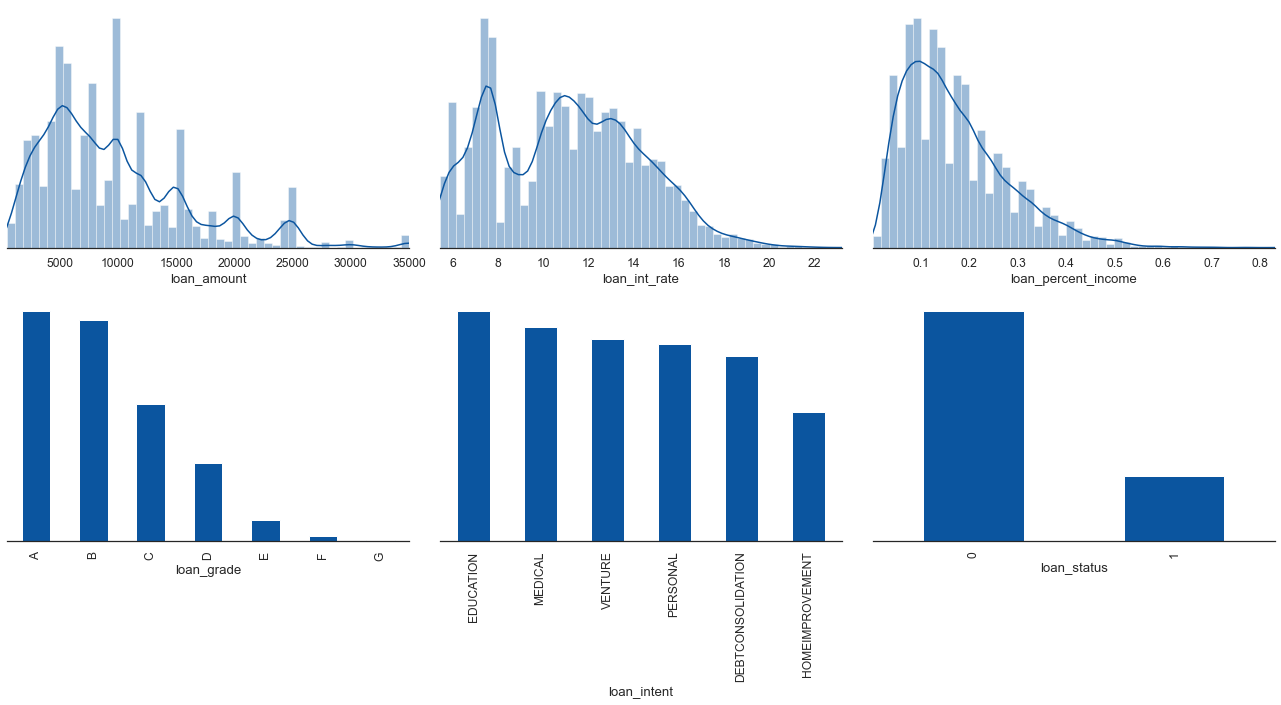

In [130]:
# Set up the matplotlib figure
f, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.despine(left=True)

# Univariate distributions

# (1) Amount of the loan
fig_amount = sns.distplot(df_loans_analysis.loan_amount,kde=True,ax=axes[0,0])
fig_amount.axis(xmin=df_loans_analysis.loan_amount.min(), xmax=df_loans_analysis.loan_amount.max())

# (2) Interest rate attached to the loan
fig_int_rate = sns.distplot(df_loans_analysis.loan_int_rate,kde=True,ax=axes[0,1])
fig_int_rate.axis(xmin=df_loans_analysis.loan_int_rate.min(), xmax=df_loans_analysis.loan_int_rate.max())

# (3) Loan amount over income of the counterparty
fig_lpi = sns.distplot(df_loans_analysis.loan_percent_income,kde=True,ax=axes[0,2])
fig_lpi.axis(xmin=df_loans_analysis.loan_percent_income.min(), xmax=df_loans_analysis.loan_percent_income.max())

# (4) Rating attached to the loan 
fig_grade = df_loans_analysis.groupby(["loan_grade"])["loan_grade"].count().sort_values(ascending=False).plot(kind="bar",ax=axes[1,0])

# (5) Counterparty intent to go for a loan
fig_intent = df_loans_analysis.groupby(["loan_intent"])["loan_intent"].count().sort_values(ascending=False).plot(kind="bar",ax=axes[1,1])

# (6) Whether the counterparty defaulted or not on the loan 
fig_status = df_loans_analysis.groupby(["loan_status"])["loan_status"].count().sort_values(ascending=False).plot(kind="bar",ax=axes[1,2])

plt.setp(axes, yticks=[])
plt.tight_layout()

[TODO] Description

[TODO] Normality?

## (2.3) A combined analysis: multivariate

In this section, we will explore dependencies between features by mergin the two datasets. Such procedure can provide further insights on the data and uncover hidden patterns in the data. Visualizations will help us in this task

Here we merge the two datasets we previously used to conduct the univariate analysis. These should be cleaned of inconsistencies as well as null values

In [137]:
# Inner join between tables
df_analysis = pd.merge(df_cp_analysis,df_loans_analysis,how="inner",left_index=True,right_index=True)

In [138]:
# Let's first explore the dataset
print(f"Dimension of the dataset: {df_analysis.shape}")
df_analysis.head()

Dimension of the dataset: (28632, 12)


cp_age  cp_income cp_home_ownership  cp_emp_length  \
1      21       9600               OWN            5.0   
2      25       9600          MORTGAGE            1.0   
3      23      65500              RENT            4.0   
4      24      54400              RENT            8.0   
5      21       9900               OWN            2.0   

  cp_person_default_on_file  cp_person_cred_hist_length loan_intent  \
1                         N                           2   EDUCATION   
2                         N                           3     MEDICAL   
3                         N                           2     MEDICAL   
4                         Y                           4     MEDICAL   
5                         N                           2     VENTURE   

  loan_grade  loan_amount  loan_int_rate  loan_status  loan_percent_income  
1          B         1000          11.14            0                 0.10  
2          C         5500          12.87            1                 0.57  
3          C        35000          15.23            1                 0.53  
4          C        35000          14.27            1                 0.55  
5          A         2500           7.14            1                 0.25

In [73]:
# Define function for plotting
def sns_multivariate(*plot_args):

    # Retrieve graph options
    plot_dict = plot_args[0]
    plot_options = plot_dict["plot_options"]

    # Settings
    plt.figure(figsize=(12,7))
    df_plot = plot_dict["df"]
    x = plot_dict["x"]
    y = plot_dict["y"]

    # Differentiate between graphs

    if plot_options["kind"] == "bar":
        g = sns.barplot(x=x, y=y, data=df_plot,palette=plot_options["palette"])
    elif plot_options["kind"] == "count":
        g = sns.countplot(x=x,hue=plot_options["hue"],palette=plot_options["palette"],order=plot_options["order"])
        g.legend(loc="upper left")
    elif plot_options["kind"] == "boxplot":
        g = sns.boxplot(data=df_plot,x=x,y=y)
    elif plot_options["kind"] == "violin":
        g = sns.violinplot(data=df_plot, x=x, y=y, hue=plot_options["hue"],inner="quart",split=True)
    elif plot_options["kind"] == "scatter":
        g = sns.scatterplot(x=x.x,y=y,data=df_plot,s=40,color="m")
    else:
        raise Exception("Not a valid graph option")

    # Options shared for each graph
    for p in g.patches:
        g.annotate(int(p.get_height()), (p.get_x() + p.get_width()/2, p.get_height()), ha='center', va='center', xytext=(0,10), textcoords = 'offset points')
    g.set_title(plot_options["title"],fontsize=20,fontweight="bold")
    g.set_xlabel(plot_options["x_label"],fontsize=16)
    g.set_ylabel(plot_options["y_label"],fontsize=16)


# TRIAL 1
# grade_df = df_cp_loans.groupby(['loan_grade'])['loan_int_rate'].mean().sort_values(ascending=True).reset_index()

# plot_args = {
#     "df": grade_df,
#     "x": "loan_grade",
#     "y": "loan_int_rate", 
#     "plot_options": {
#         "kind": "bar",
#         "title": "Average interest rate per rating",
#         "x_label": "Rating",
#         "y_label": "Interest rate",
#         "palette":"Blues"
#     }
# }

# plot_args = {
#     "df": df,
#     "x": "loan_grade",
#     "y": "loan_int_rate", 
#     "plot_options": {
#         "kind": "violin",
#         "hue": "loan_status",
#         "title": "Distribution of loan amount per rating in case of default or not",
#         "x_label": "Rating",
#         "y_label": "Interest rate",
#         "palette": {1: "Defaulted", 0: "Not defaulted"}
#     }
# }

# sns_plot(plot_args)  

## TRIAL 1
# grade_df = df_cp_loans.groupby(['loan_grade'])['loan_int_rate'].mean().plot(kind='bar')
# plot_args = {
#     "kind": "bar",
#     "title": "Average interest rate per rating",
#     "x_label": "Rating",
#     "y_label": "Interest rate"
# }


# (3) Data manipulation 

In [14]:
# mapping defaulted on file into 0-1 variables
mapping_defaulted = {
    "Y":1,
    "N":0
}
# modify the dataframe to respect this convention
df.loc[:,'cp_person_default_on_file'] = df.cp_person_default_on_file.map(mapping_defaulted)

# assert 
assert not np.any((df.cp_person_default_on_file == "N") & (df.cp_person_default_on_file == "Y"))

As a last step, let's turn the non-numeric variables into categorical.

In [15]:
# Get categorical variables
for col in ('cp_home_ownership','cp_person_default_on_file','loan_intent','loan_grade','loan_status'):
    df[col] = pd.Categorical(df[col])

# check 
df.dtypes

cp_age                           int64
cp_income                        int64
cp_home_ownership             category
cp_emp_length                  float64
cp_person_default_on_file     category
cp_person_cred_hist_length       int64
loan_intent                   category
loan_grade                    category
loan_amount                      int64
loan_int_rate                  float64
loan_status                   category
loan_percent_income            float64
dtype: object

### Plotting

In [43]:
#df_cp_loans.

In [44]:
# df_cp_loans.groupby(['loan_grade','loan_status'])['loan_status'].count().plot(kind='bar')

# Here new stuff to merge!

In order to better understand the data we are working with we will carefully analyze each single variable closely to try to understand its meaning and relevance for the problem at hand. If properly handle, this process can ease our analysis and provide with additional information and insights before proceeding into modelling. Preparing a table/dataframe with the following attributes for each of the remaining variable would turn out to be of extremely good use:

* **Variable**: name of the variable
* **Type**: either "categorical" (factor) or numerical (number)
* **Segment**: we could categorize the variable into "n" segments: 

    * Counterparty: variables that give information regarding counterparties 
    * Loans: information on the loan issued to a counterparty
    * Default: either inform on the chance of default a loan has, or whether the counterparty has already defaulted in the past
    
* **Expectation**: our expectation of the influence of this variable on the dependent variable (e.g. either "High","Medium","Low" impact)
* **Conclusion**: our conclusion after taking a look at the data (using same scale as "Expectation" for comparison purposes)
* **Comment**: comment on the result, with a particular focus on describing the difference between expectation and conclusion

This process will help us in setting up what in a statistical setting, and to be more precise, in a Bayesian context a person would call "prior information": we expect that some variables will have a higher impact on the variable that we are trying to model (what we defined "expectation"). The aim of the analysis then is to update such belief and retrieve the "posterior information", or in other words, the updated prior (what we defined "conclusion"). Why is this procedure relevant anyway? To understand this point, consider the following example: [TODO] -> provide an example where not considering prior information might lead you misinterpretation in the conclusion of viceversa


### Let's have a closer look at the counterparties characteristics

In [66]:
# Retrieve counterparty data
cp_cols_num = ['cp_age','cp_income','cp_emp_length','cp_person_default_on_file','cp_person_cred_hist_length']
cp_cols_cat = ['cp_home_ownership','cp_person_default_on_file']

# Get the data
df_cp_num = df_analysis[cp_cols_num]
df_cp_cat = df_analysis[cp_cols_num]

Exception: Not a valid graph option

In [ ]:
# Counterparties attributes
plot_args = {
    "df": df_cp_num,
    "x": "index",
    "y": "loan_status", 
    "plot_options": {
        "kind": "pairplot",
        "title": "Distribution of counterparties attributes",
        "x_label": "Not defaulted vs. defaulted loans",
        "y_label": "Frequency",
        "palette": "icefire"
    }
}

# Plot
sns_plot(plot_args)

### (3.1) First things first: dig into the dependent variable 

In [56]:
# Retrieve the data
df_ls = df_analysis['loan_status'].value_counts().reset_index()

# Mapping to correct values
ls_dict = {
    0: 'Not defaulted (=0)',
    1: 'Defaulted (=1)'
}
df_ls['index'] = df_ls['index'].map(ls_dict)

# Retrieve loan status
df_ls

index  loan_status
0  Not defaulted (=0)        22430
1      Defaulted (=1)         6202

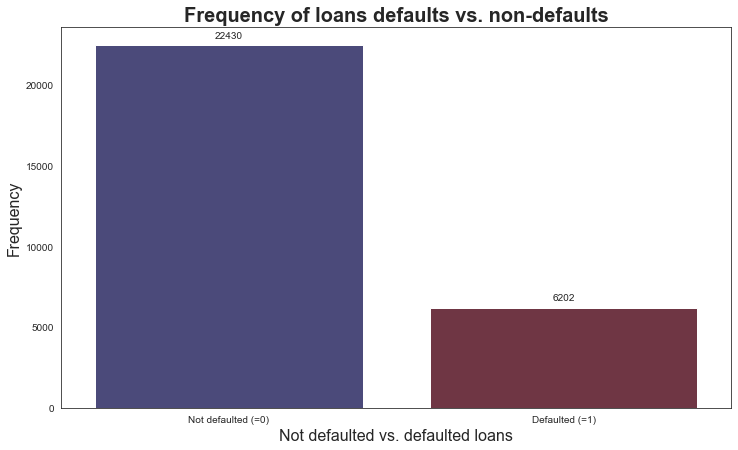

In [57]:
# Distribution of "loan_status" -> dependent variable
plot_args = {
    "df": df_ls,
    "x": "index",
    "y": "loan_status", 
    "plot_options": {
        "kind": "bar",
        "title": "Frequency of loans defaults vs. non-defaults",
        "x_label": "Not defaulted vs. defaulted loans",
        "y_label": "Frequency",
        "palette": "icefire"
    }
}

# Get the distribution
sns_plot(plot_args)

Comment: unbalanced class of defaulted vs. non-defaulted counterparties in the dataset. However, this is not a classification, but a regression task. Hence, overbalancing (SMOTE) is not required in this situation, as it is normal to assume that the class of non-defaulted clients is the one that is represented the most in this context.

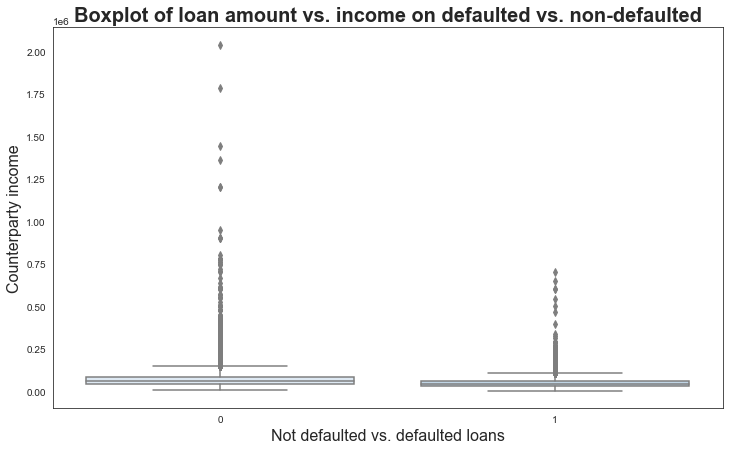

In [63]:
# How is the distribution of income across these categories of loans?
# Loan-status vs. cp_income
plot_args = {
    "df": df_analysis,
    "x": "loan_status",
    "y": "cp_income", 
    "plot_options": {
        "kind": "boxplot",
        "title": "Boxplot of loan amount vs. income on defaulted vs. non-defaulted",
        "x_label": "Not defaulted vs. defaulted loans",
        "y_label": "Counterparty income",
        "palette": "icefire"
    }
}

# Get the distribution
sns_plot(plot_args)

It can be noticed that most of the counterparties in both groups seem to have low income. This fact might be given by the strong presence of young people representing counterparties, who might have lower salaries/income with respect to older people, and thus more inclined to default on such loans. Let's have a closer look at this hypothesis

In [74]:
# Loan-status vs. interest rate
plot_args = {
    "df": df_analysis,
    "x": "cp_income",
    "y": "cp_age", 
    "plot_options": {
        "kind": "scatter",
        "title": "",
        "x_label": "",
        "y_label": "",
        "palette": "",
        "type": "mult"
    }
}

# Get the distribution
sns_plot(plot_args)

AttributeError: 'str' object has no attribute 'x'

In [ ]:
# Loan-status vs. interest rate
plot_args = {
    "df": df_analysis,
    "x": "index",
    "y": "loan_status", 
    "plot_options": {
        "kind": "violin",
        "title": "Frequency of loans defaults vs. non-defaults",
        "x_label": "Not defaulted vs. defaulted loans",
        "y_label": "Frequency",
        "palette": "icefire"
    }
}

# Get the distribution
sns_plot(plot_args)